In [16]:
# !pip install google_play_scraper
# !pip install textblob
# !pip install seaborn

## Data Collection ##

Initial Setup

In [57]:
from google_play_scraper import app
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import textblob
import nltk
from collections import Counter
from nltk.tokenize import word_tokenize
from pathlib import Path
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score
from PIL import Image
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.stem import WordNetLemmatizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory


%matplotlib inline
%config InlineBackend.figure_format='retina'

# Import seaborn styles explicitly
import seaborn as sns
# Apply the seaborn style before creating plots
sns.set_style("whitegrid")  # This line sets the Seaborn style

plt.rcParams["figure.figsize"] = (15,10)

Get data from = "https://play.google.com/store/apps/details?id=com.gsm.customer.global&hl=id" an app customer to order an online taxi

In [18]:
#https://play.google.com/store/apps/details?id=com.gsm.customer.global&hl=id


from google_play_scraper import app, Sort, reviews_all

jkn_reviews = reviews_all(
    'com.gsm.customer.global',
    sleep_milliseconds=0, # defaults to 0
    lang='en', # defaults to 'en'
    sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
)

Save the data into a dataframe

In [19]:
df_jknrev = pd.DataFrame(np.array(jkn_reviews),columns=['content'])
df_jknrev = df_jknrev.join(pd.DataFrame(df_jknrev.pop('content').tolist()))

Mask username

In [20]:
def mask_username(username):
    if pd.isna(username):
        return username
    username = str(username)
    if len(username) <= 4:
        return "*" * len(username)
    return username[:2] + "*" * (len(username)-4) + username[-2:]

df_jknrev['userName'] = df_jknrev['userName'].apply(mask_username)

Save raw data (with username masking) to csv

In [21]:
df_jknrev.to_csv("df_jknrev.csv", index=False)

In [22]:
df_jknrev

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,daf6a8a8-55cb-49f2-ab8d-234bb99e1037,Ta********ni,https://play-lh.googleusercontent.com/a-/ALV-U...,blok c 11,5,0,4.8.1,2025-08-31 12:14:10,None,None,4.8.1
1,e3b153d4-044d-444d-b80e-1aa2269d286d,****,https://play-lh.googleusercontent.com/a/ACg8oc...,cepat kurang dari 10menit,5,0,4.8.1,2025-08-30 20:35:13,None,None,4.8.1
2,acbbf537-12b0-4dab-a4e3-224176d9df41,Yu*******ar,https://play-lh.googleusercontent.com/a-/ALV-U...,you need to improve the accuracy of the map an...,3,0,4.9.0,2025-08-29 16:42:38,None,None,4.9.0
3,76bc3abc-ad97-4331-a3ce-34f5413e457b,Ro****ES,https://play-lh.googleusercontent.com/a-/ALV-U...,Really fall in love with the clean and tidy car,5,0,4.8.1,2025-08-28 22:57:46,None,None,4.8.1
4,1c836ad0-5d92-4fdd-bf33-559484c7f6dd,Mo*****************el,https://play-lh.googleusercontent.com/a-/ALV-U...,saya pernah minta ganti rute pakai apps jarak ...,2,0,4.9.0,2025-08-28 17:10:38,None,None,4.9.0
...,...,...,...,...,...,...,...,...,...,...,...
176,da3fb7e4-61a1-4049-bd26-35732e2380e2,fi********am,https://play-lh.googleusercontent.com/a/ACg8oc...,"telah kirim ke email keluhan, paling bener nai...",1,17,3.36.1,2025-04-06 17:58:59,None,None,3.36.1
177,8d13bacc-1d77-4999-9c70-672fb54c3ef7,Ra*********ra,https://play-lh.googleusercontent.com/a-/ALV-U...,"Don't waste your time using this online taxi, ...",1,31,None,2025-04-05 16:46:42,None,None,None
178,55d3f7de-f9a0-4839-bfd8-940b3adeeed9,Ac*******ia,https://play-lh.googleusercontent.com/a-/ALV-U...,MOBIL TAKSI PALING NYAMAN. GAK BERISIK. AC DIN...,5,5,None,2025-04-03 20:44:10,None,None,None
179,57f1a7ca-f458-465e-b885-8f53a4dd48d2,Iv******ro,https://play-lh.googleusercontent.com/a/ACg8oc...,The cars used for Green SM taxis are very nice...,5,1,3.36.1,2025-04-03 07:55:59,None,None,3.36.1


In [23]:
df_jknrev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              181 non-null    object        
 1   userName              181 non-null    object        
 2   userImage             181 non-null    object        
 3   content               181 non-null    object        
 4   score                 181 non-null    int64         
 5   thumbsUpCount         181 non-null    int64         
 6   reviewCreatedVersion  154 non-null    object        
 7   at                    181 non-null    datetime64[ns]
 8   replyContent          0 non-null      object        
 9   repliedAt             0 non-null      object        
 10  appVersion            154 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 15.7+ KB


# Data preprocessing #

# a. without tokenization and stemmering

Lowercasing

In [24]:
df_jknrev['content'] = df_jknrev['content'].astype(str)# Before lowercasing
# Before lowercasing
print ("Before lowercasing:")
print(df_jknrev['content'][11])
print(df_jknrev['content'][1])
print(df_jknrev['content'][20])
print ("\nAfter lowercasing:")
df_jknrev['content']= df_jknrev['content'].apply(lambda x: x.lower())
print(df_jknrev['content'][11])
print(df_jknrev['content'][1])
print(df_jknrev['content'][20])

Before lowercasing:
layanan puas dan terbaik
cepat kurang dari 10menit
Nice and easy app for transportation

After lowercasing:
layanan puas dan terbaik
cepat kurang dari 10menit
nice and easy app for transportation


Tokenization

In [25]:
df_jknrev['tokens'] = df_jknrev['content'].str.lower().str.split()
all_tokens = [word for tokens in df_jknrev['tokens'] for word in tokens]
counter = Counter(all_tokens)
top_50 = counter.most_common(50)
print(top_50)

[('the', 56), ('and', 48), ('dan', 43), ('to', 38), ('driver', 37), ('di', 29), ('i', 28), ('ga', 24), ('tidak', 20), ('is', 20), ('app', 19), ('taxi', 18), ('good', 17), ('yang', 16), ('my', 16), ('ada', 16), ('mobil', 15), ('saya', 14), ('mobilnya', 14), ('aplikasi', 14), ('ke', 14), ('this', 14), ('bisa', 13), ('for', 13), ('with', 12), ('banyak', 12), ('it', 11), ('a', 11), ('sudah', 11), ('yg', 11), ('car', 10), ('tapi', 10), ('banget', 10), ('drivernya', 10), ('sangat', 10), ('green', 10), ('not', 10), ('taksi', 9), ('ramah', 9), ('ini', 9), ('nice', 9), ('pake', 9), ('untuk', 9), ('aplikasinya', 9), ('baru', 9), ('pick', 9), ('very', 9), ('of', 8), ('in', 8), ('nyaman', 8)]


Stopword removal

In [59]:
# Create stopword remover
factory = StopWordRemoverFactory()
id_stopwords = set(factory.get_stop_words())

# Apply stopword removal to the 'content' column
df_jknrev['tokens_stopword_rm'] = df_jknrev['tokens'].apply(lambda tokens: [w for w in tokens if w not in id_stopwords])

In [60]:
nltk.download('stopwords')

english_stopwords = set(stopwords.words('english'))

df_jknrev['tokens_stopword_rm'] = df_jknrev['tokens_stopword_rm'].apply(
    lambda tokens: [w for w in tokens if w not in english_stopwords]
)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Viggo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [61]:
print(df_jknrev['tokens_stopword_rm'])

0                                                                                                                                                       [blok, c, 11]
1                                                                                                                                            [cepat, kurang, 10menit]
2                                                                             [need, improve, accuracy, map, better, driver, reached, phone, instead, long, texting.]
3                                                                                                                              [really, fall, love, clean, tidy, car]
4                                      [pernah, minta, ganti, rute, pakai, apps, jarak, lebih, dekat, argo, lebih, mahal, beda, 10rb,, hah,, ngga, tau, siapa, error]
                                                                                    ...                                                                              
176 

In [ ]:
# Download WordNet (only once)
nltk.download('wordnet')
nltk.download('omw-1.4')

# English Lemmatizer
lemmatizer = WordNetLemmatizer()

# Indonesian Stemmer
factory = StemmerFactory()
indo_stemmer = factory.create_stemmer()

# Function to stem/lemmatize per token
def stem_or_lemmatize(tokens):
    processed = []
    for w in tokens:
        # Simple heuristic: check if word is ASCII (likely English)
        if w.isascii():
            processed.append(lemmatizer.lemmatize(w))
        else:
            processed.append(indo_stemmer.stem(w))
    return processed

# Apply to your DataFrame
df_jknrev['tokens_stemmed'] = df_jknrev['tokens'].apply(stem_or_lemmatize)

print(df_jknrev[['tokens', 'tokens_stemmed']].head())


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Viggo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Viggo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


                                                                                                                           tokens  \
0                                                                                                                   [blok, c, 11]   
1                                                                                                        [cepat, kurang, 10menit]   
2                                         [need, improve, accuracy, map, better, driver, reached, phone, instead, long, texting.]   
3                                                                                          [really, fall, love, clean, tidy, car]   
4  [pernah, minta, ganti, rute, pakai, apps, jarak, lebih, dekat, argo, lebih, mahal, beda, 10rb,, hah,, ngga, tau, siapa, error]   

                                                                                                                   tokens_stemmed  
0                                                                    

In [62]:
# Recombine stemmed tokens back into strings
df_jknrev['clean_text'] = df_jknrev['tokens_stemmed'].apply(lambda x: ' '.join(x))

In [63]:
from textblob import TextBlob

# On raw text (as originally written)
df_jknrev['raw_polarity'] = df_jknrev['content'].astype(str).apply(lambda x: TextBlob(x).polarity)
df_jknrev['raw_subjectivity'] = df_jknrev['content'].astype(str).apply(lambda x: TextBlob(x).subjectivity)

# On cleaned/stemmed text
df_jknrev['clean_polarity'] = df_jknrev['clean_text'].astype(str).apply(lambda x: TextBlob(x).polarity)
df_jknrev['clean_subjectivity'] = df_jknrev['clean_text'].astype(str).apply(lambda x: TextBlob(x).subjectivity)


Create a new dataframe for relevant columns

In [28]:
df_analysis = df_jknrev.loc[:,["content","score","thumbsUpCount", "reviewCreatedVersion", "at", "replyContent", "repliedAt"]]

In [29]:
#Check number of reviews scores
df_jknrev['score'].value_counts()

score
5    105
1     52
3     11
2      9
4      4
Name: count, dtype: int64

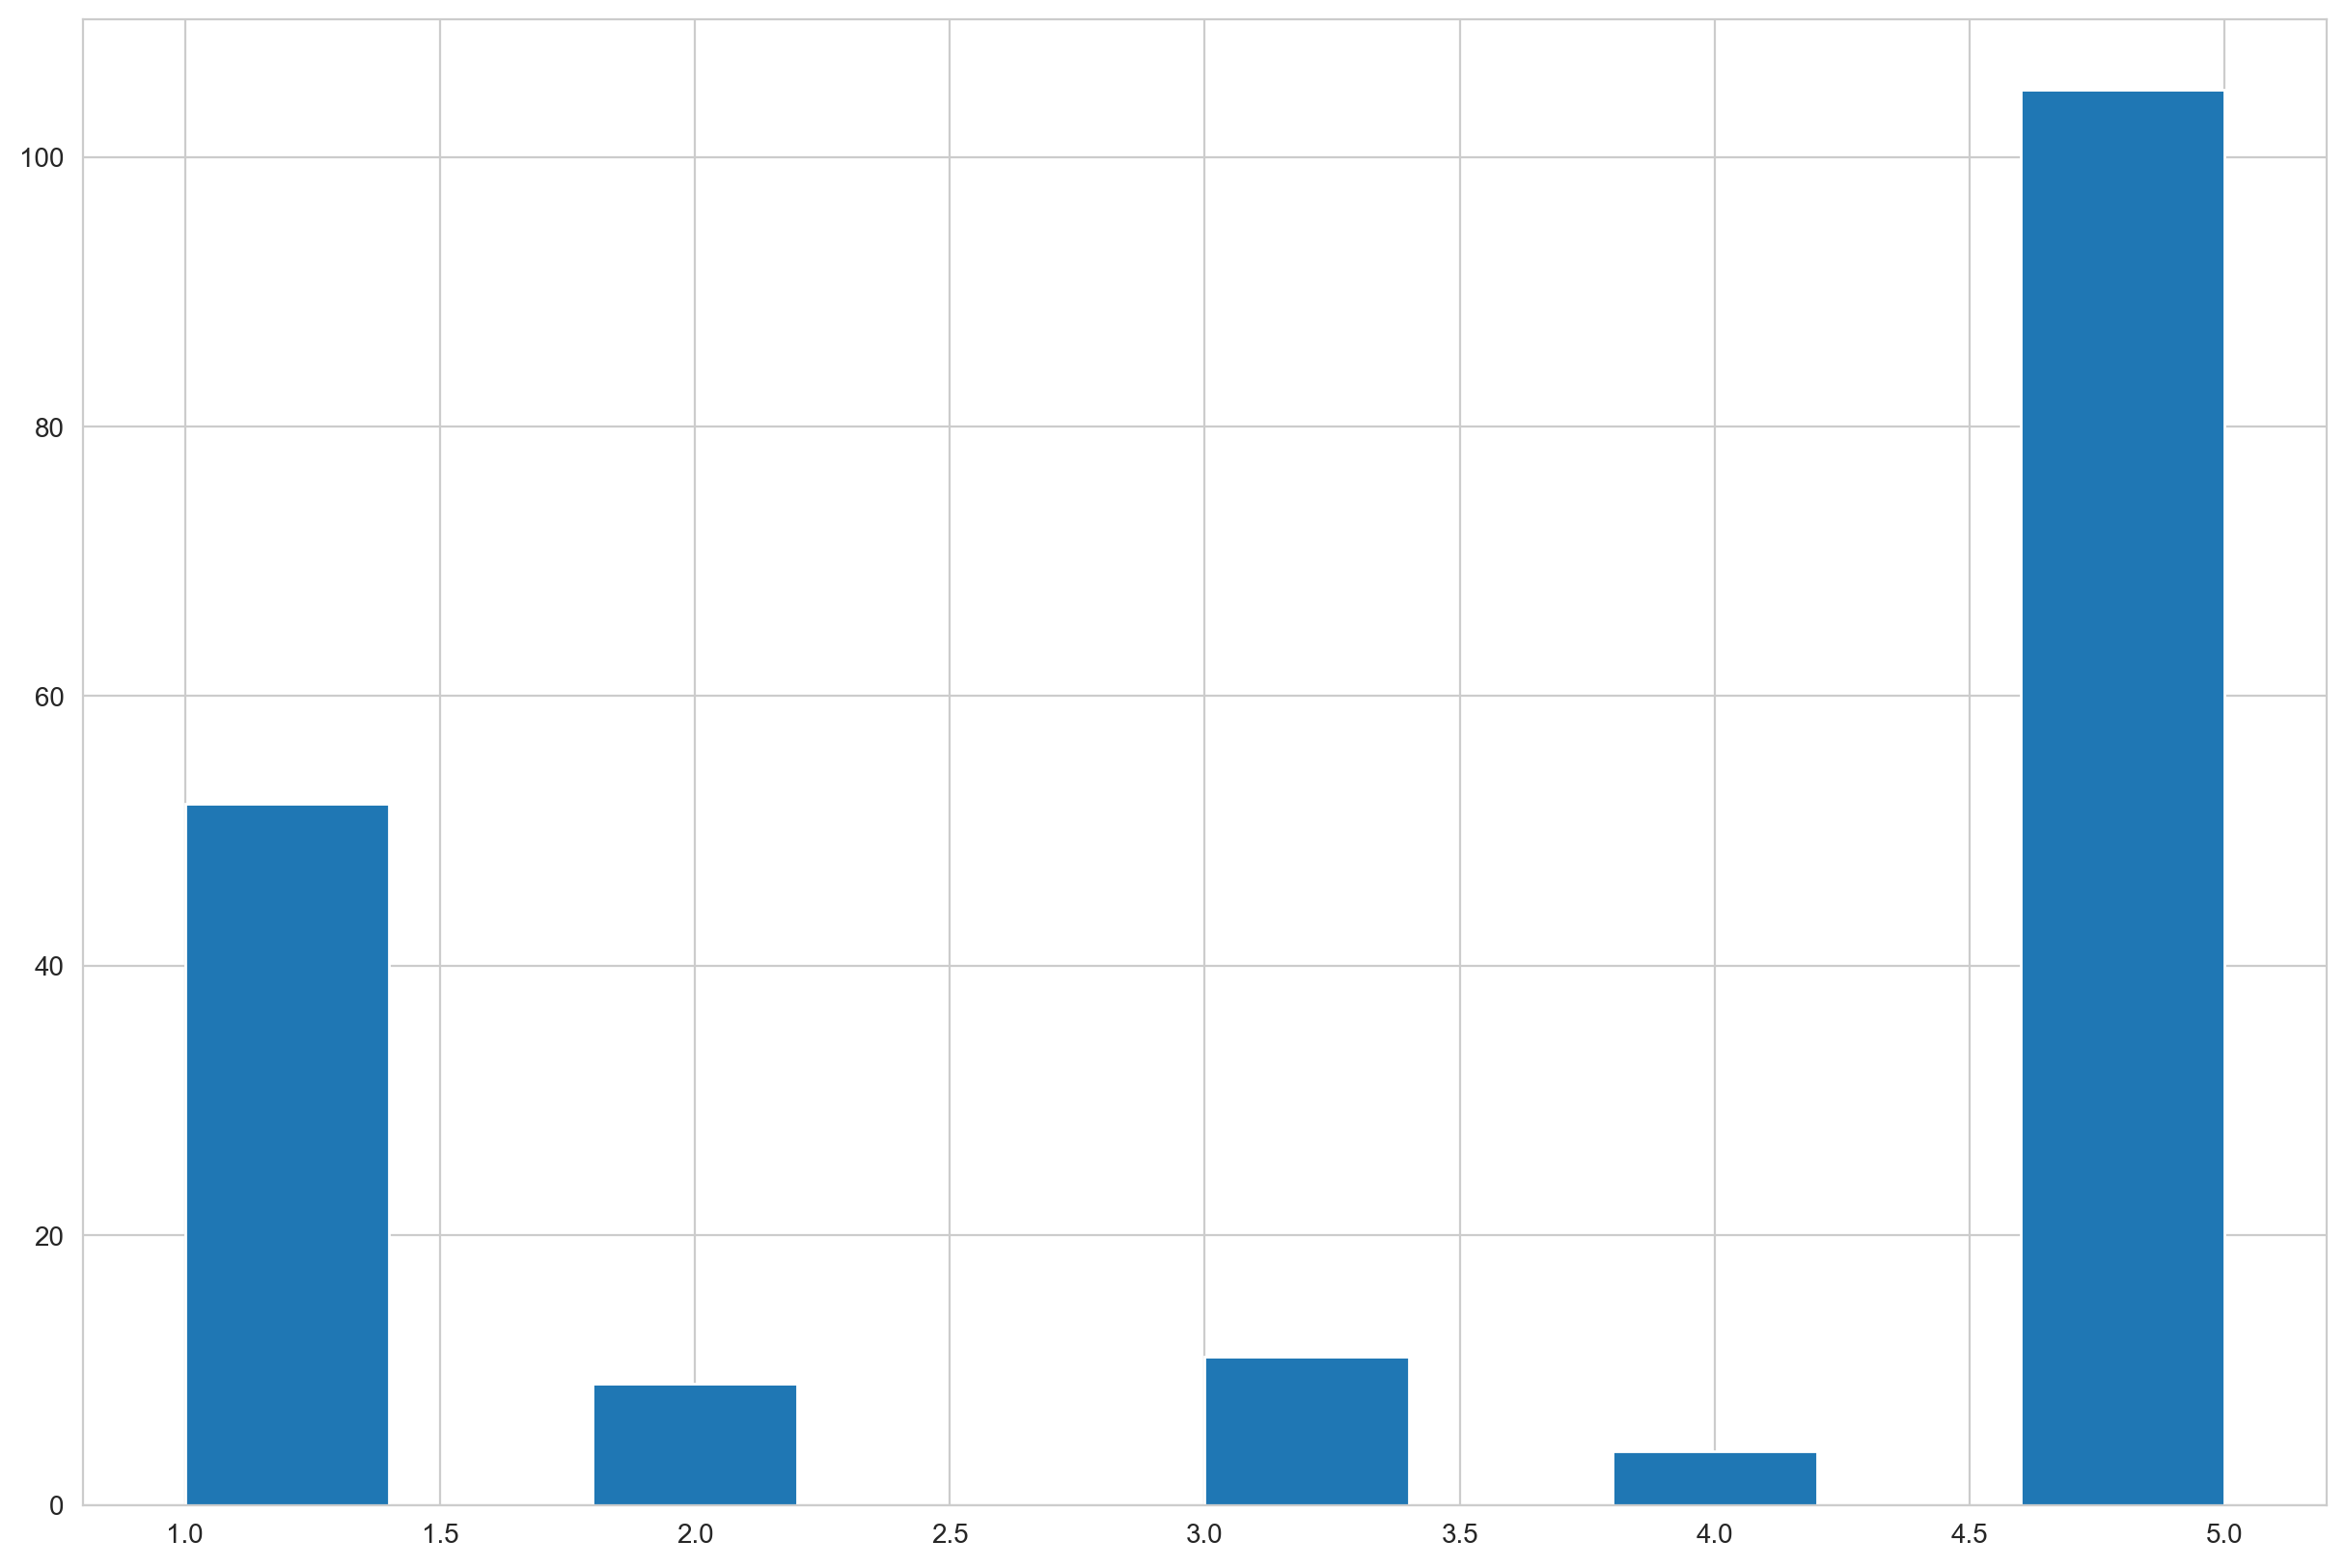

In [30]:
plt.hist(df_jknrev['score'])
plt.show()

In [31]:
import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 200)
#from pandas_profiling import ProfileReport
import regex
import nltk
import wordcloud
import textblob

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

import string
import re
import emoji

In [32]:
#Creating polarity on the column: content (review from the apps) using TextBlob
#Read https://textblob.readthedocs.io/en/dev/quickstart.html

from textblob import TextBlob
# Handle None values in 'content' column by replacing them with empty strings
df_jknrev['sentiment_polarity'] = df_jknrev['content'].astype(str).apply(lambda x: TextBlob(x).polarity)
df_jknrev['sentiment_subjective'] = df_jknrev['content'].astype(str).apply(lambda x: TextBlob(x).subjectivity)

In [64]:
df_raw = df_jknrev.loc[:,["content","score","raw_polarity", "raw_subjectivity"]]
df_clean = df_jknrev.loc[:,["content","score","clean_polarity", "clean_subjectivity"]]

In [65]:
df_raw

,content,score,raw_polarity,raw_subjectivity
0,blok c 11,5,0.000000,0.000000
1,cepat kurang 10menit,5,0.000000,0.000000
2,need improve accuracy map better driver reached phone instead long texting.,3,0.225000,0.450000
3,really fall love clean tidy car,5,0.416667,0.575000
4,"pernah minta ganti rute pakai apps jarak lebih dekat argo lebih mahal beda 10rb, hah, ngga tau siapa error",2,0.000000,0.000000
...,...,...,...,...
176,"kirim email keluhan, paling bener naik grab/gojek/blubird",1,0.000000,0.000000
177,"waste time using online taxi, driver rude driving dangerously humiliated lot first ride them. never going use ever",1,-0.212500,0.458333
178,mobil taksi paling nyaman. gak berisik. ac dingin.. rute kelapa gading kemayoran murah. driver ramah.,5,0.000000,0.000000
179,"cars used green sm taxis nice luxurious, service friendly.",5,0.258333,0.600000


In [66]:
df_clean

,content,score,clean_polarity,clean_subjectivity
0,blok c 11,5,0.000000,0.000000
1,cepat kurang 10menit,5,0.000000,0.000000
2,need improve accuracy map better driver reached phone instead long texting.,3,0.225000,0.450000
3,really fall love clean tidy car,5,0.416667,0.575000
4,"pernah minta ganti rute pakai apps jarak lebih dekat argo lebih mahal beda 10rb, hah, ngga tau siapa error",2,0.000000,0.000000
...,...,...,...,...
176,"kirim email keluhan, paling bener naik grab/gojek/blubird",1,0.000000,0.000000
177,"waste time using online taxi, driver rude driving dangerously humiliated lot first ride them. never going use ever",1,-0.212500,0.458333
178,mobil taksi paling nyaman. gak berisik. ac dingin.. rute kelapa gading kemayoran murah. driver ramah.,5,0.000000,0.000000
179,"cars used green sm taxis nice luxurious, service friendly.",5,0.258333,0.600000


In [34]:
#DATA PREPROCESSING
# Lower casing
# Change the reviews type to string
df_jknrev['content'] = df_jknrev['content'].astype(str)# Before lowercasing
# Before lowercasing
print(df_jknrev['content'][11])
print(df_jknrev['content'][1])
print(df_jknrev['content'][20])

layanan puas dan terbaik
cepat kurang dari 10menit
nice and easy app for transportation


In [35]:
#Lowercase all reviews to see the difference
df_jknrev['content']= df_jknrev['content'].apply(lambda x: x.lower())
print(df_jknrev['content'][11])
print(df_jknrev['content'][1])
print(df_jknrev['content'][20])

layanan puas dan terbaik
cepat kurang dari 10menit
nice and easy app for transportation


In [36]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Get Indonesian stopwords
indonesian_stopwords = stopwords.words('indonesian')

# Display first 20 stopwords
print(indonesian_stopwords[:20])

['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya', 'aku', 'akulah', 'amat', 'amatlah', 'anda', 'andalah', 'antar', 'antara']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Viggo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
import string

df_jknrev['wordCount'] = [len(review.split()) for review in df_jknrev['content']]
df_jknrev['uppercaseCharCount'] = [sum(char.isupper() for char in review) \
    for review in df_jknrev['content']]
df_jknrev['specialCharCount'] = [sum(char in string.punctuation for char in review) \
    for review in df_jknrev['content']]

In [38]:
df_jknrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","wordCount","uppercaseCharCount","specialCharCount"]]

,content,score,sentiment_polarity,sentiment_subjective,wordCount,uppercaseCharCount,specialCharCount
0,blok c 11,5,0.000000,0.000000,3,0,0
1,cepat kurang dari 10menit,5,0.000000,0.000000,4,0,0
2,you need to improve the accuracy of the map and it will be better if your driver can be reached by phone instead of long texting.,3,0.225000,0.450000,26,0,1
3,really fall in love with the clean and tidy car,5,0.416667,0.575000,10,0,0
4,"saya pernah minta ganti rute pakai apps jarak lebih dekat tapi argo lebih mahal beda 10rb, hah, ngga tau siapa yang error",2,0.000000,0.000000,22,0,2
...,...,...,...,...,...,...,...
176,"telah kirim ke email keluhan, paling bener naik grab/gojek/blubird",1,0.000000,0.000000,9,0,3
177,"don't waste your time using this online taxi, the driver is very rude and driving very dangerously i was humiliated a lot during my first ride with them. never going to use them again ever",1,-0.280000,0.528333,35,0,3
178,mobil taksi paling nyaman. gak berisik. ac dingin.. rute kelapa gading ke kemayoran juga murah. driver ramah.,5,0.000000,0.000000,17,0,6
179,"the cars used for green sm taxis are very nice and luxurious, and the service is friendly.",5,0.318333,0.600000,17,0,2


In [39]:
#Add a column name polarity_rating from changing the score of the review into 3 labels: Pos, Negative Neutral
df_jknrev['sentiment_rating'] = df_jknrev['score'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3  else 'Negative'))

In [40]:
df_jknrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","sentiment_rating"]]

,content,score,sentiment_polarity,sentiment_subjective,sentiment_rating
0,blok c 11,5,0.000000,0.000000,Positive
1,cepat kurang dari 10menit,5,0.000000,0.000000,Positive
2,you need to improve the accuracy of the map and it will be better if your driver can be reached by phone instead of long texting.,3,0.225000,0.450000,Neutral
3,really fall in love with the clean and tidy car,5,0.416667,0.575000,Positive
4,"saya pernah minta ganti rute pakai apps jarak lebih dekat tapi argo lebih mahal beda 10rb, hah, ngga tau siapa yang error",2,0.000000,0.000000,Negative
...,...,...,...,...,...
176,"telah kirim ke email keluhan, paling bener naik grab/gojek/blubird",1,0.000000,0.000000,Negative
177,"don't waste your time using this online taxi, the driver is very rude and driving very dangerously i was humiliated a lot during my first ride with them. never going to use them again ever",1,-0.280000,0.528333,Negative
178,mobil taksi paling nyaman. gak berisik. ac dingin.. rute kelapa gading ke kemayoran juga murah. driver ramah.,5,0.000000,0.000000,Positive
179,"the cars used for green sm taxis are very nice and luxurious, and the service is friendly.",5,0.318333,0.600000,Positive


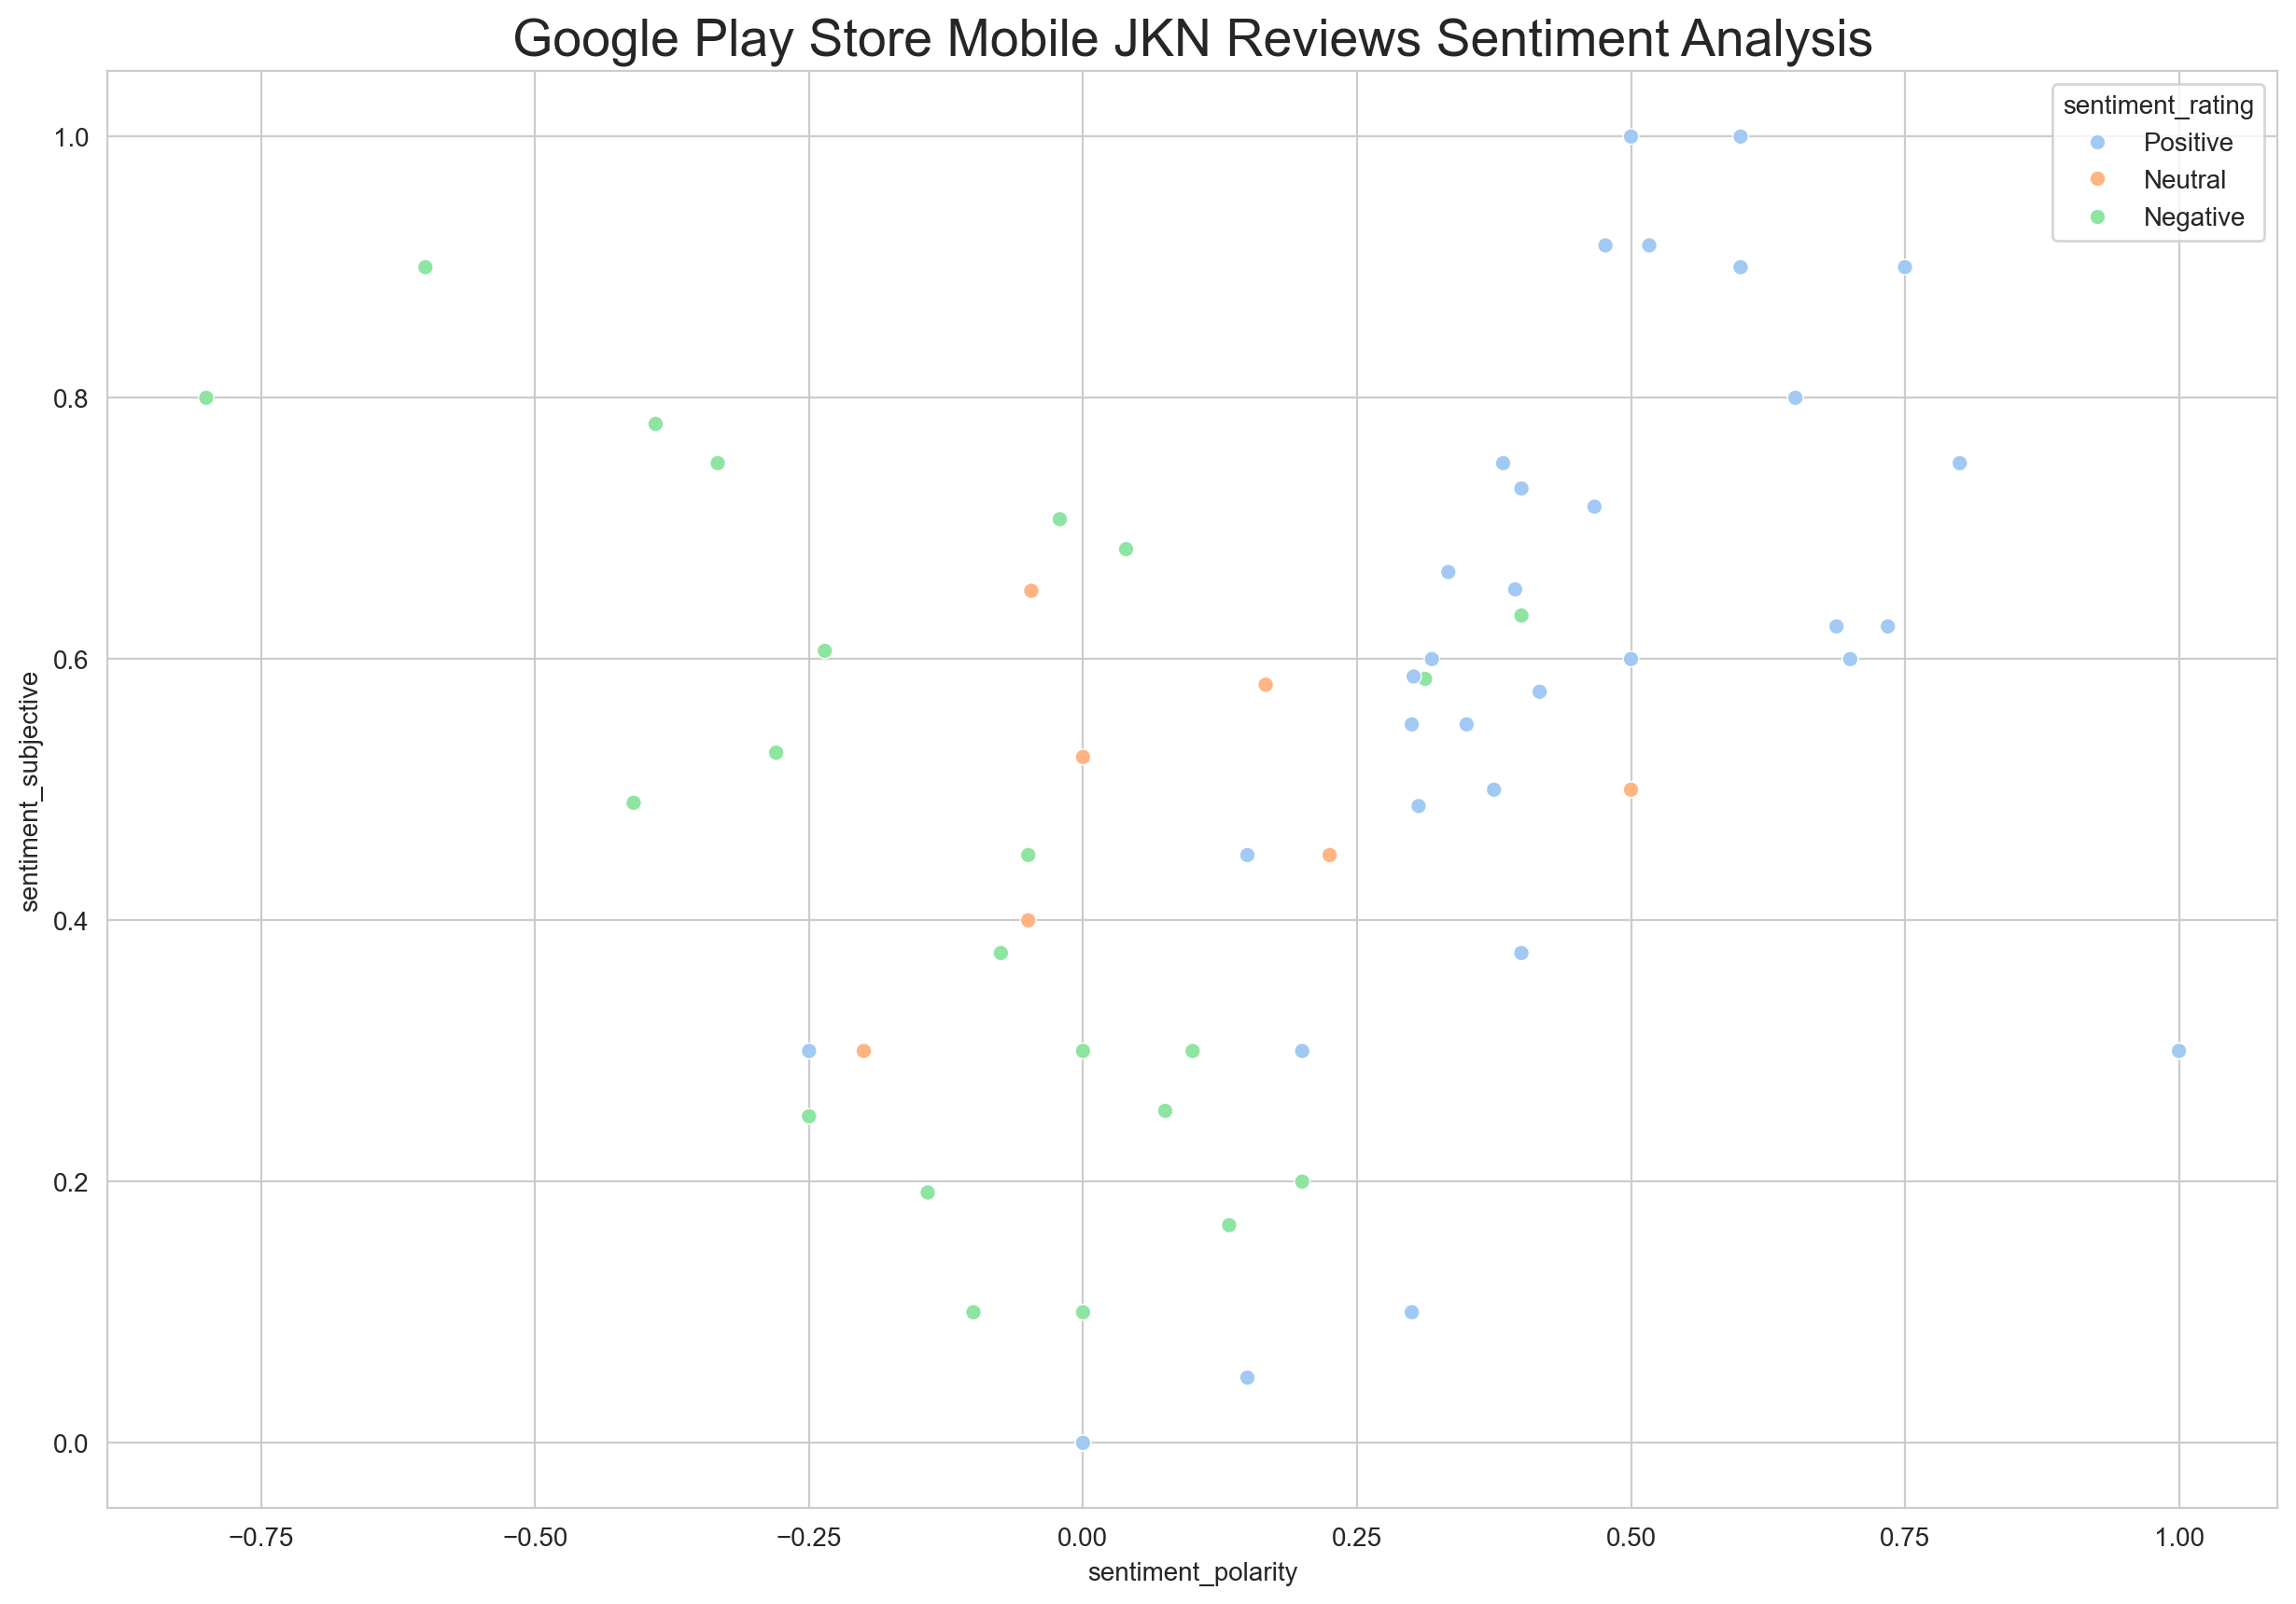

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
# Specify x and y using the 'x' and 'y' parameters within sns.scatterplot
sns.scatterplot(x=df_jknrev['sentiment_polarity'], y=df_jknrev['sentiment_subjective'],
                hue=df_jknrev['sentiment_rating'], edgecolor='white', palette="pastel")
plt.title("Google Play Store Mobile JKN Reviews Sentiment Analysis", fontsize=20)
plt.show()

In [42]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  #Import FreqDist from nltk.probability
  from nltk.probability import FreqDist
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms)
  plt.figure(figsize=(20,5))
  # Use the 'rainbow' colormap for the bar plot
  ax = sns.barplot(data=d, x= "word", y = "count", palette="rainbow")
  ax.set(ylabel = 'Count')
  plt.show()

C:\Users\Viggo\AppData\Local\Temp\ipykernel_7928\2152088084.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=d, x= "word", y = "count", palette="rainbow")


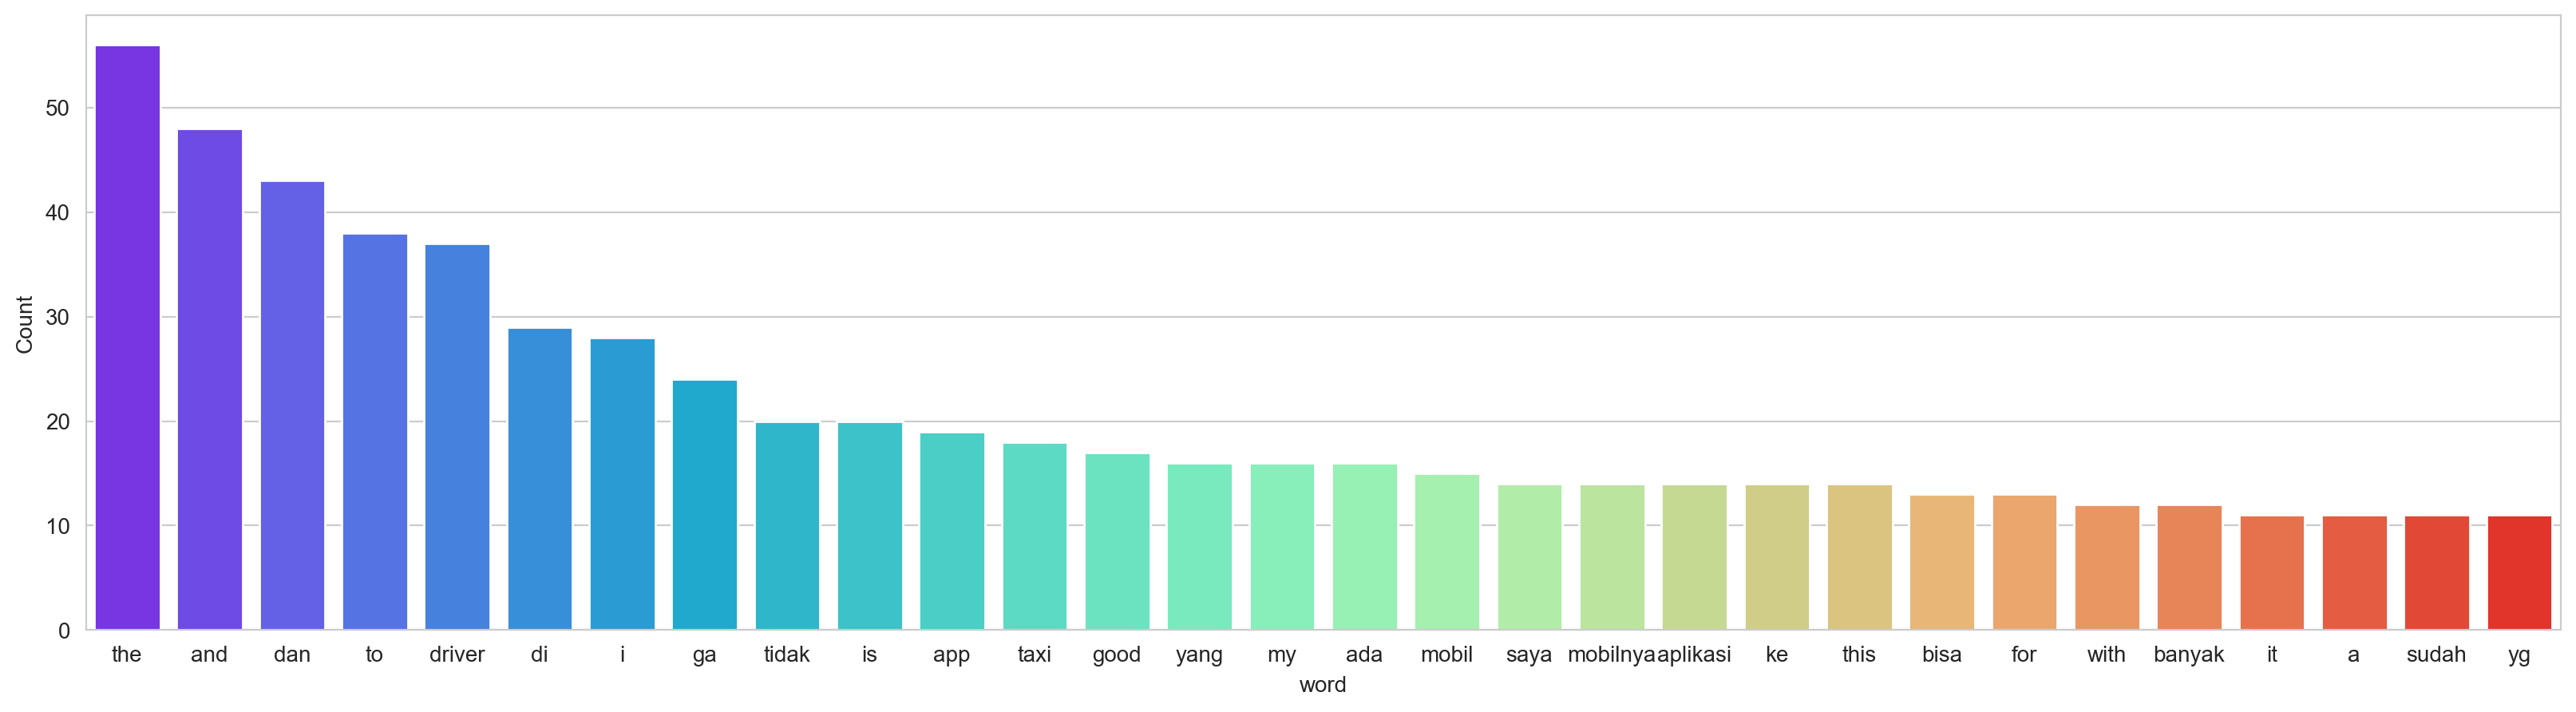

In [43]:
freq_words(df_jknrev['content'])

In [44]:
# prompt: the [content] column hasnt been applied Indonesian stopwords removal using Sastrawi

# !pip install Sastrawi

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Create stopword remover
factory = StopWordRemoverFactory()
stopword_remover = factory.create_stop_word_remover()

# Apply stopword removal to the 'content' column
df_jknrev['content'] = df_jknrev['content'].apply(lambda x: stopword_remover.remove(x))


In [45]:
# prompt: can you also apply English stopwords as well to the [content] column

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Get English stopwords
english_stopwords = stopwords.words('english')

# Assuming df_jknrev is your DataFrame and 'content' is the column
df_jknrev['content'] = df_jknrev['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in english_stopwords]))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Viggo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
len(english_stopwords)

198

In [47]:
df_jknrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","sentiment_rating"]]

,content,score,sentiment_polarity,sentiment_subjective,sentiment_rating
0,blok c 11,5,0.000000,0.000000,Positive
1,cepat kurang 10menit,5,0.000000,0.000000,Positive
2,need improve accuracy map better driver reached phone instead long texting.,3,0.225000,0.450000,Neutral
3,really fall love clean tidy car,5,0.416667,0.575000,Positive
4,"pernah minta ganti rute pakai apps jarak lebih dekat argo lebih mahal beda 10rb, hah, ngga tau siapa error",2,0.000000,0.000000,Negative
...,...,...,...,...,...
176,"kirim email keluhan, paling bener naik grab/gojek/blubird",1,0.000000,0.000000,Negative
177,"waste time using online taxi, driver rude driving dangerously humiliated lot first ride them. never going use ever",1,-0.280000,0.528333,Negative
178,mobil taksi paling nyaman. gak berisik. ac dingin.. rute kelapa gading kemayoran murah. driver ramah.,5,0.000000,0.000000,Positive
179,"cars used green sm taxis nice luxurious, service friendly.",5,0.318333,0.600000,Positive


In [48]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  #Import FreqDist from nltk.probability
  from nltk.probability import FreqDist
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms)
  plt.figure(figsize=(20,5))
  # Use the 'rainbow' colormap for the bar plot
  ax = sns.barplot(data=d, x= "word", y = "count", palette="rainbow")
  ax.set(ylabel = 'Count')
  plt.show()

C:\Users\Viggo\AppData\Local\Temp\ipykernel_7928\2152088084.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=d, x= "word", y = "count", palette="rainbow")


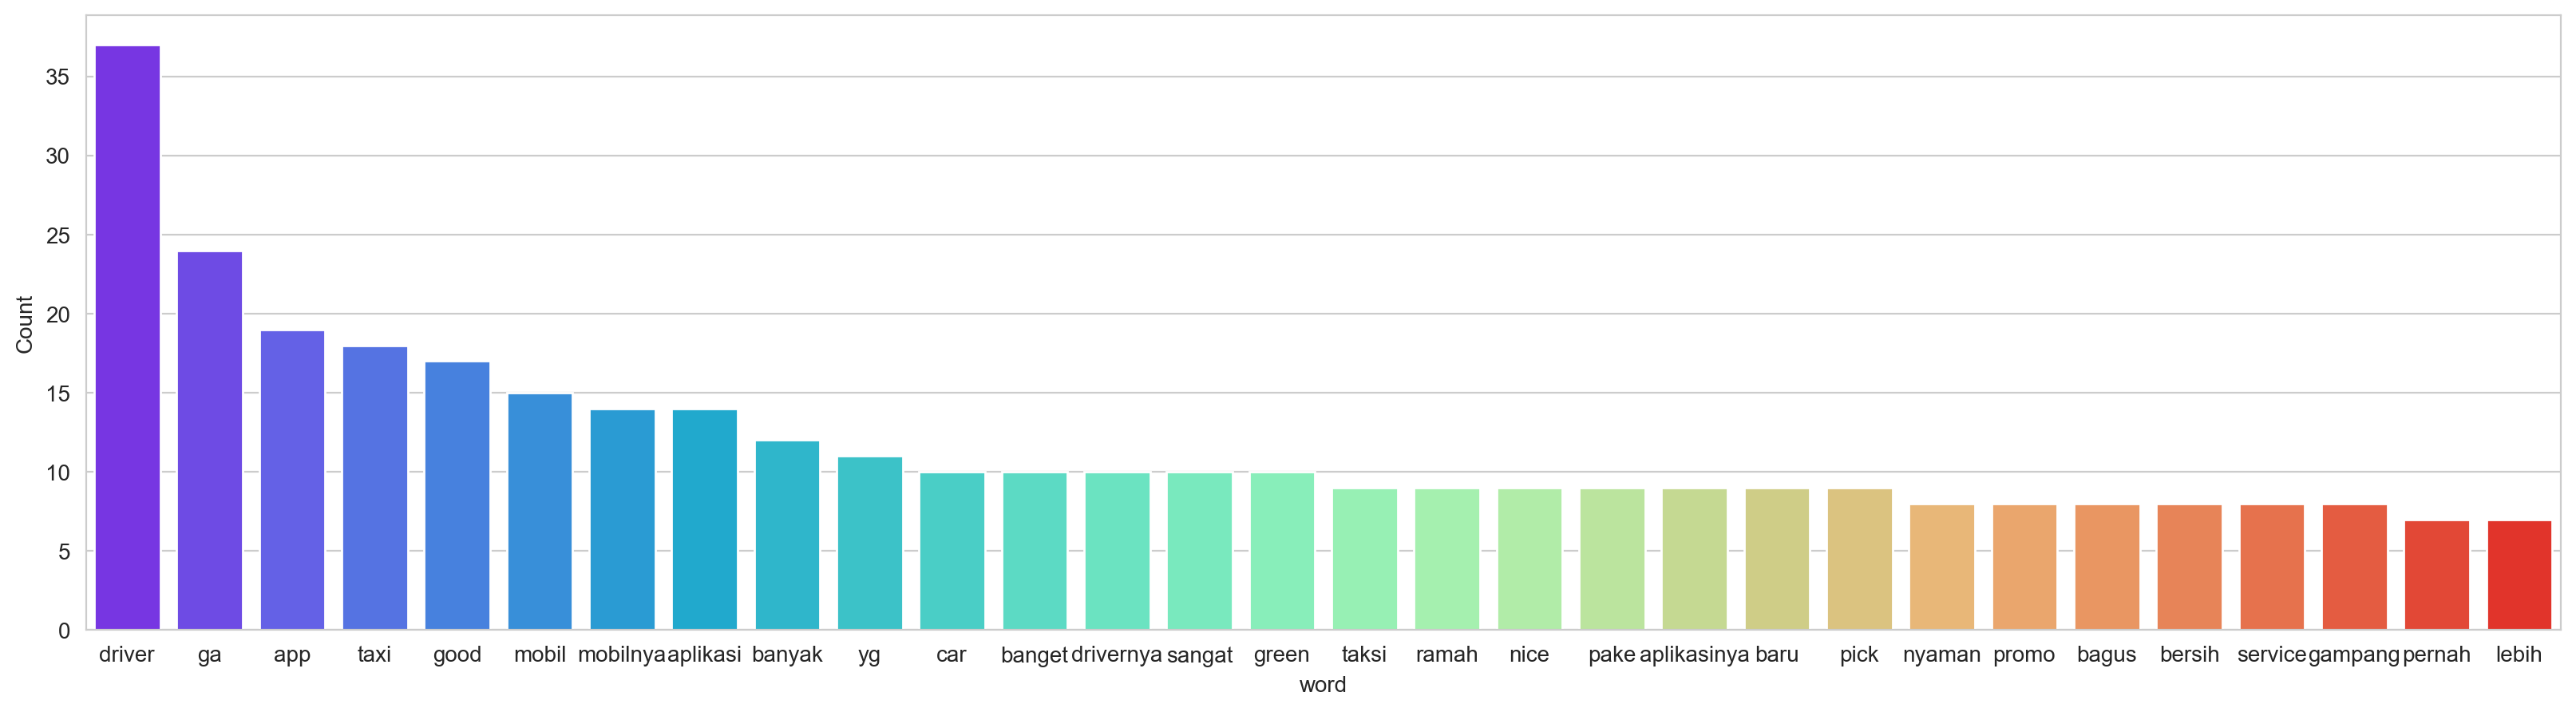

In [49]:
freq_words(df_jknrev['content'])

In [50]:
custom_stopwords = {"ga", "yg", "aplikasi", "app"}
# Assuming df_jknrev is your DataFrame and 'content' is the column
df_jknrev['content'] = df_jknrev['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in custom_stopwords]))


In [51]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  #Import FreqDist from nltk.probability
  from nltk.probability import FreqDist
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms)
  plt.figure(figsize=(20,5))
  # Use the 'rainbow' colormap for the bar plot
  ax = sns.barplot(data=d, x= "word", y = "count", palette="rainbow")
  ax.set(ylabel = 'Count')
  plt.show()

C:\Users\Viggo\AppData\Local\Temp\ipykernel_7928\2152088084.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=d, x= "word", y = "count", palette="rainbow")


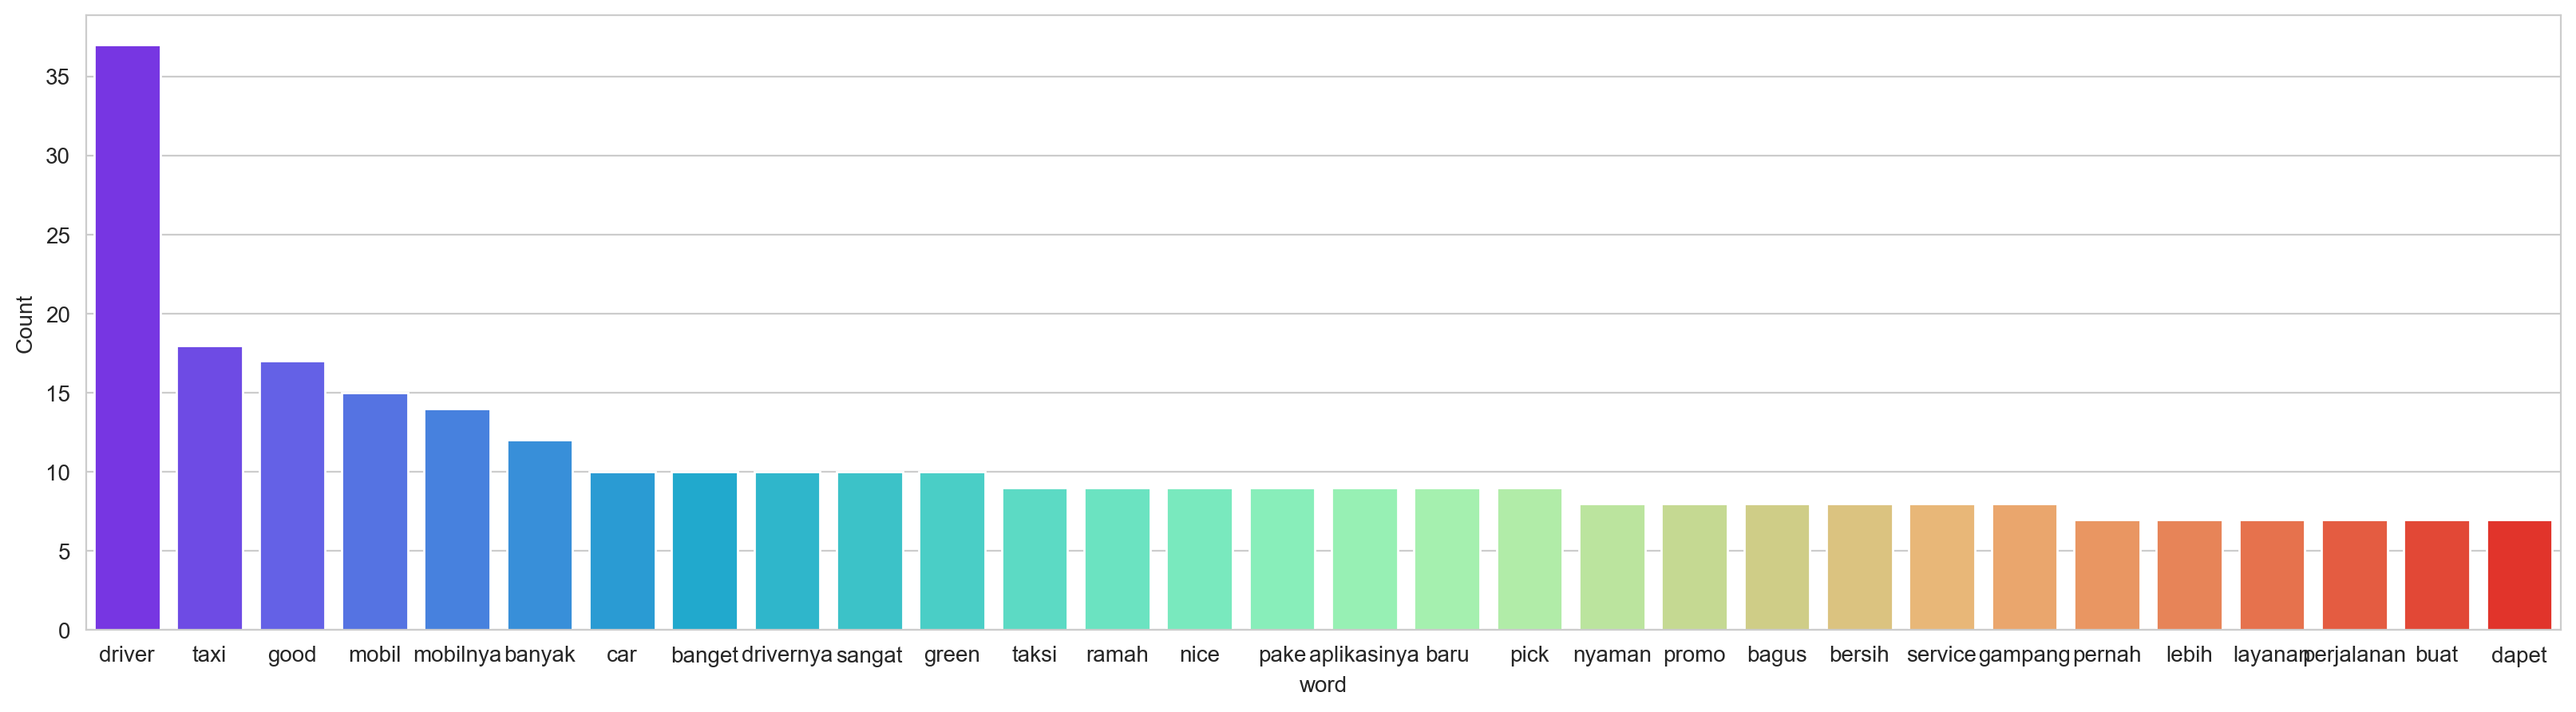

In [52]:
freq_words(df_jknrev['content'])